- UK に限定して分析を進める。
  - 売上改善施策は、
    - UK
    - UK 以外
  - で考えられる。UK 以外は 課題A で挙げている国に限定する。

In [1]:
import time 

from IPython.core.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('ggplot')
import numpy as np
import seaborn as sns
sns.set(font='Osaka')
import pandas as pd

In [2]:
t0 = time.time()
data_dir = '../data/'
file = 'df_item_transaction.csv'
df_item_transaction = pd.read_csv(data_dir + file)
print('Load in ', time.time() - t0)

Load in  0.8886580467224121


In [54]:
country = 'United Kingdom'
df_uk = \
df_item_transaction[df_item_transaction['Country'] == country].drop('Unnamed: 0', axis=1)

# CustomerID to Nominal
df_uk['CustomerID'] = df_uk['CustomerID'].fillna('NaN')

# InvoiceDate to Datetime
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])

display(df_uk.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [55]:
assert df_uk['StockCode'].nunique() == 3910
assert df_uk['CustomerID'].nunique() == 3918

print('# of distinct items =', df_uk['StockCode'].nunique())
print('# of distinct customers =', df_uk['CustomerID'].nunique())

# of distinct items = 3910
# of distinct customers = 3918


In [64]:
# Customer ごとにデータを集計　
# Recency
# Frequency = #ofTransactions
# Monetary = sum(Sales)

# Sales: min, max, median, mean, sum
# Quantity: min, max, median, mean, sum
# Quantity / Transaction: min, max, median, mean
# Unitprice: min, max, median, mean

# Item / Transaction = 商品の種類 / Transaction: min, max, median, mean


# 各商品をいくつ購入したか？　(3,910 items hence the same # of columns)

# TODO:
# ある商品を購入する顧客は Frequency が大きいといった関係が発見できるか？
# RMF 分析で優良顧客を見つけ出し、彼らの 2月, 4月の


# Monetary
df_uk_per_customer = \
pd.DataFrame(df_uk.groupby('CustomerID')['Sales'].sum()).reset_index()\
.rename(columns={'Sales': 'Monetary'})

# Frequency
df_uk_per_customer['Frequency'] = \
pd.DataFrame(df_uk.groupby('CustomerID')['InvoiceNo'].nunique()).reset_index()['InvoiceNo']
# small test
test_customer = 12748
assert df_uk_per_customer[df_uk_per_customer['CustomerID'] == test_customer]['Frequency'].values\
            == df_uk[df_uk['CustomerID'] == test_customer]['InvoiceNo'].nunique()

# Recency
# 基準日
df_uk_per_customer['ReferenceDate'] = \
    pd.to_datetime(df_item_transaction['InvoiceDate']).max()
# 最終購入日
df_uk_per_customer['LastTransactionDate'] = \
    pd.DataFrame(df_uk.groupby('CustomerID')['InvoiceDate'].max()).reset_index()['InvoiceDate']
# 基準日 - 最終購入日
df_uk_per_customer['Recency(Day)'] = \
(df_uk_per_customer['ReferenceDate'].dt.date - df_uk_per_customer['LastTransactionDate'].dt.date).dt.days


# sum(Quantity)
df_uk_per_customer['QuantitySum'] = pd.DataFrame(df_uk.groupby('CustomerID')['Quantity'].sum()).reset_index()['Quantity']

# Quantity / Transaction
df_uk_per_customer['QuantityPerTransaction'] = df_uk_per_customer['QuantitySum'] / df_uk_per_customer['Frequency']

display(df_uk_per_customer.head())

,CustomerID,Monetary,Frequency,ReferenceDate,LastTransactionDate,Recency(Day),QuantitySum,QuantityPerTransaction
0,12346,77183.60,1,2011-12-09 12:50:00,2011-01-18 10:01:00,325,74215,74215.000000
1,12747,4196.01,11,2011-12-09 12:50:00,2011-12-07 14:34:00,2,1275,115.909091
2,12748,32317.32,206,2011-12-09 12:50:00,2011-12-09 12:20:00,0,25511,123.839806
3,12749,4040.88,5,2011-12-09 12:50:00,2011-12-06 09:56:00,3,1470,294.000000
4,12820,942.34,4,2011-12-09 12:50:00,2011-12-06 15:12:00,3,722,180.500000


/Users/fujiki/anaconda3/envs/DataScience/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


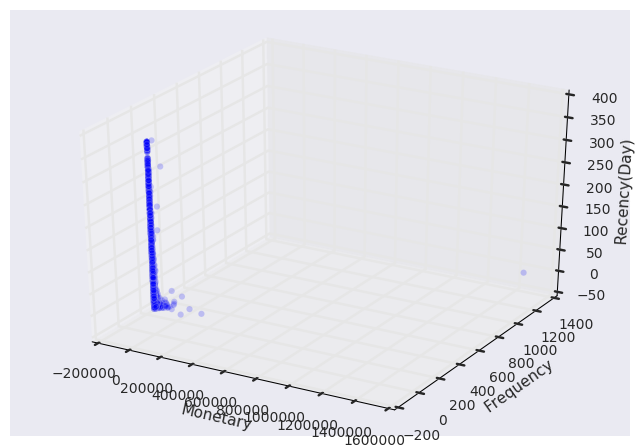

In [7]:
# 3D plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = 'Monetary'
y = 'Frequency'
z = 'Recency(Day)'
ax.scatter(
    xs=df_uk_per_customer[x], 
    ys=df_uk_per_customer[y], 
    zs=df_uk_per_customer[z],
    alpha=0.2
)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
plt.show()

# NOTE:
# Monetary と Frequency が飛び抜けているカスタマーがいる。

In [8]:
# Monetary と Frequency が飛び抜けているカスタマーの正体は、
# CustomerID = NaN

df_uk_per_customer.sort_values('Monetary', ascending=False).head()

,CustomerID,Monetary,Frequency,ReferenceDate,LastTransactionDate,Recency(Day)
3917,NaN,1482450.84,1324,2011-12-09 12:50:00,2011-12-09 10:26:00,0
3780,18102,259657.30,60,2011-12-09 12:50:00,2011-12-09 11:50:00,0
3312,17450,194550.79,46,2011-12-09 12:50:00,2011-12-01 13:29:00,8
2597,16446,168472.50,2,2011-12-09 12:50:00,2011-12-09 09:15:00,0
3354,17511,91062.38,31,2011-12-09 12:50:00,2011-12-07 10:12:00,2


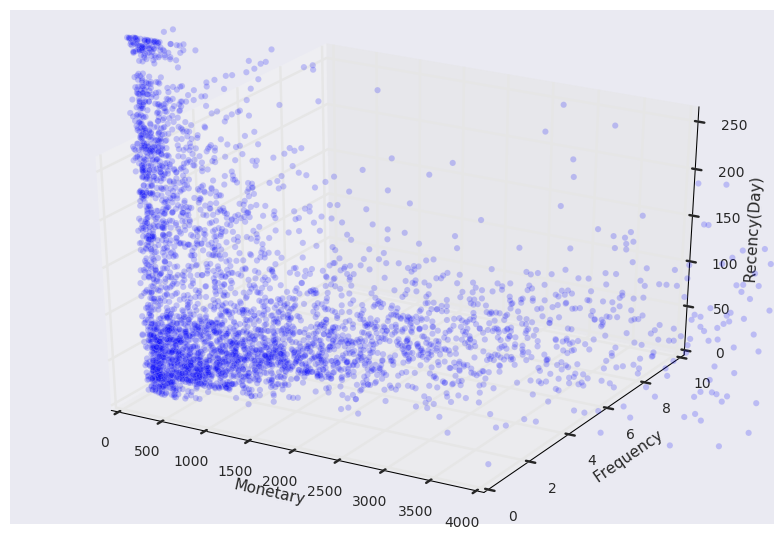

In [9]:
# 3D plot
# CustomerID = NaN を除外

df_plot = df_uk_per_customer[df_uk_per_customer['CustomerID'] != 'NaN']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = 'Monetary'
y = 'Frequency'
z = 'Recency(Day)'
ax.scatter(xs=df_plot[x], ys=df_plot[y], zs=df_plot[z], alpha=0.2)
ax.set_xlim(0, 4000)
ax.set_ylim(0, 10)
ax.set_zlim(0, 260)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
plt.tight_layout()
plt.show()

# NOTE:
# Monetary と Frequency が小さいカスタマーの Recency は ばらついている。
# 一方、Monetary と Frequency が大きいカスタマーの Recency は それほどばらついていなく、それほど大きくもない。

In [15]:
# CustomerID = NaN のカスタマを除外する

df_uk_per_customer = df_uk_per_customer[df_uk_per_customer['CustomerID'] != 'NaN']
display(df_uk_per_customer.describe(percentiles=[.25, .5, .75, .9]))

,Monetary,Frequency,Recency(Day)
count,3917.000000,3917.000000,3917.000000
mean,1854.998017,4.235384,91.893541
std,7435.726313,7.159409,99.750225
min,3.750000,1.000000,0.000000
25%,299.340000,1.000000,17.000000
50%,650.430000,2.000000,50.000000
75%,1571.030000,5.000000,143.000000
90%,3407.256000,9.000000,261.000000
max,259657.300000,206.000000,373.000000


In [16]:
df_uk_per_customer.head()

,CustomerID,Monetary,Frequency,ReferenceDate,LastTransactionDate,Recency(Day)
0,12346,77183.60,1,2011-12-09 12:50:00,2011-01-18 10:01:00,325
1,12747,4196.01,11,2011-12-09 12:50:00,2011-12-07 14:34:00,2
2,12748,32317.32,206,2011-12-09 12:50:00,2011-12-09 12:20:00,0
3,12749,4040.88,5,2011-12-09 12:50:00,2011-12-06 09:56:00,3
4,12820,942.34,4,2011-12-09 12:50:00,2011-12-06 15:12:00,3


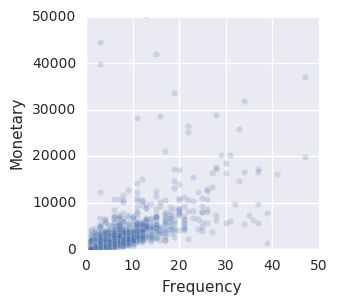

In [24]:
# Frequency と　Monetary の関係
figsize = (3, 3)
x = 'Frequency'
y = 'Monetary'
df_uk_per_customer.plot(kind='scatter', x=x, y=y, alpha=0.2, figsize=figsize)
plt.xlim(0, 50)
plt.ylim(0, 50000)
plt.show()

In [ ]:
# Frequency に影響を与える因子を見つけ出せるか？

In [ ]:
# Recency に影響を与える因子を見つけ出せるか？

In [ ]:
# Quantity / Transaction と Monetary の関係

In [50]:
# カスタマごとに何をどれだけ購入したかを一覧

df_uk_customer_item = \
pd.DataFrame(df_uk[df_uk['CustomerID'] != 'NaN'].groupby(['CustomerID', 'StockCode'])['Quantity'].sum())\
.reset_index()\
.pivot(index='CustomerID', columns='StockCode', values='Quantity')\
.fillna(0)

print(df_uk_customer_item.shape)
display(df_uk_customer_item.head())

(3917, 3641)


StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z,BANK CHARGES,PADS
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12747.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12748.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,28.0,36.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12820.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df_uk_per_customer_item = \
df_uk_per_customer.set_index('CustomerID')\
.join(df_uk_customer_item, how='left')

print(df_uk_per_customer_item.shape)

(3917, 3646)


In [67]:
df_uk_per_customer['QuantityPerTransaction'].describe()

count     3918.000000
mean       244.131066
std       1374.576267
min          1.000000
25%         90.500000
50%        156.583333
75%        262.491667
max      74215.000000
Name: QuantityPerTransaction, dtype: float64

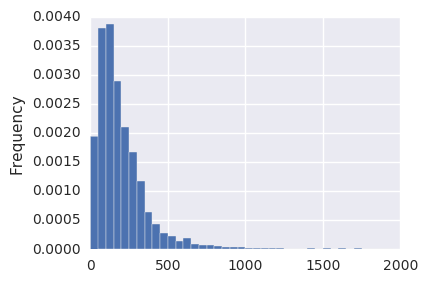

In [74]:
figsize = (4, 3)
bins = np.arange(0, 2000, 50)
df_uk_per_customer['QuantityPerTransaction'].plot(kind='hist', bins=bins, figsize=figsize, normed=True)
plt.show()

In [94]:
X.shape

(3917, 3641)

In [95]:
y.shape

(3918,)

In [97]:
# Quantity / Transaction を target として予測?
# ある商品を購入しているカスタマは Q / T が高い、とか。

X = df_uk_customer_item.values
y = df_uk_per_customer[df_uk_per_customer['CustomerID'] != 'NaN']['QuantityPerTransaction'].values


# Q / T の外れ値を除外
Q3 = np.percentile(y, 75)
Q1 = np.percentile(y, 25)
IQ = Q3 - Q1

not_outlier_identifier = (y >= Q1 - 1.5 * IQ) & (y <= Q3 + 1.5 * IQ)
y_trimmed = y[not_outlier_identifier]
print('y without outliers: ', y_trimmed.shape)
X_trimmed = X[not_outlier_identifier]
print('X without outliers: ', X_trimmed.shape)

y without outliers:  (3697,)
X without outliers:  (3697, 3641)


In [99]:
# # of outliers
sum(~not_outlier_identifier)

220

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)#, stratify=True)

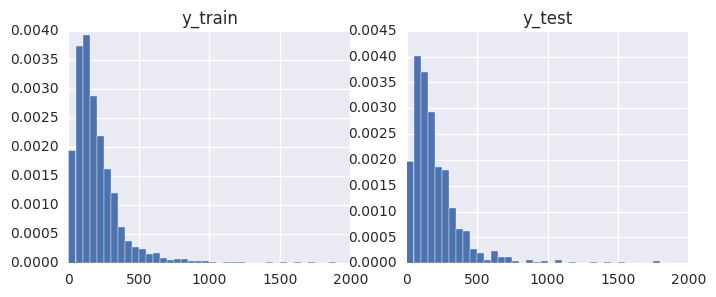

In [113]:
figsize = (8, 3)
bins = np.arange(0, 2000, 50)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
ax1.hist(y_train, bins=bins, normed=True)
ax1.set_title('y_train')
ax2.hist(y_test, bins=bins, normed=True)
ax2.set_title('y_test')
plt.show()

# train と test の分布は類似しているので OK